In [1]:
%autosave 5

Autosaving every 5 seconds


In [2]:
from jax import config

config.update("jax_enable_x64", True)

import numpy as onp
import matplotlib.pyplot as plt
import jax.numpy as np
from jax import lax
import os, argparse, pickle
from tqdm import tqdm


plt.rcParams.update(
    {
        "mathtext.fontset": "stix",
        "font.family": "STIXGeneral",
        "legend.fontsize": 14,  # this is the font size in legends
        "xtick.labelsize": 14,  # this and next are the font of ticks
        "ytick.labelsize": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 18,  # this is the fonx of axes labels
        "savefig.format": "pdf",  # how figures should be saved
        "legend.edgecolor": "0.0",
        "legend.framealpha": 1.0,
    }
)

linewidth = 2
plasmamap = plt.get_cmap("plasma")

In [3]:
data_length = onp.load("sander_initial_length.npz", allow_pickle=True)

data_growth_rate = data_length["growth_rate"]
data_initial_length = data_length["initial_length"]
fitres_length_growth = onp.polyfit(data_growth_rate, onp.log(data_initial_length), 1)
l_init_fun = lambda gr: onp.exp(fitres_length_growth[1] + fitres_length_growth[0] * gr)

In [4]:
gamma = 0.25  # slow growth
gamma = 1.0  # fast growth
T = onp.log(2) / gamma * 60 * 60
l_init = l_init_fun(gamma)
k10 = 0.002
kn1 = 0.003  # corresponding to a half-life of ~ 5 mins

gamma_seconds = gamma / 60 / 60
k1 = k10 * (1 + gamma_seconds / kn1)

gamma, T, l_init

(1.0, 2495.329850015803, 2.857025067814533)

In [5]:
Dp_list = np.array([0.018, 0.023, 0.028])

In [6]:
parser = argparse.ArgumentParser(description="MavQ_4species_V1_1")
parser.add_argument("--L", type=int, default=1, help="rescaled length")
parser.add_argument("--N", type=int, default=128)

parser.add_argument("--k1", type=float, default=k1, help="k1")
parser.add_argument("--kn1", type=float, default=kn1, help="kn1")

parser.add_argument("--chip", type=float, default=0.2)
parser.add_argument("--chin", type=float, default=0.4)
parser.add_argument("--chinp", type=float, default=1.2)

parser.add_argument("--Vn", type=float, default=10.0, help="nucleoid volume")
parser.add_argument("--Vp", type=float, default=5.0, help="polysome volume")

parser.add_argument(
    "--lmda", type=float, default=0.03, help="interface width, in micron"
)
parser.add_argument(
    "--Dn",
    type=float,
    default=5e-3,  # this is the value used for sander  data
    help="diffusion coefficient of nucleoid, in micron^2/s",
)
parser.add_argument(
    "--Dp",
    type=float,
    default=0.023,  # this is the value used for sander data
    help="diffusion coefficient of polysomes, in micron^2/s",
)

parser.add_argument("--T", type=float, default=T, help="total elongation time (in s)")
parser.add_argument(
    "--T-init", type=float, default=4000, help="total initialization time (in s)"
)
parser.add_argument("--dt", type=float, default=0.01, help="time step (in s)")
parser.add_argument(
    "--l-center", type=float, default=0.15, help="initial nucleoid length "
)
parser.add_argument(
    "--phi-center-n", type=float, default=0.6, help="initial nucleoid concentration"
)
parser.add_argument(
    "--phi-center-p", type=float, default=0.02, help="initial polysome concentration"
)
parser.add_argument(
    "--phi-boundary-n", type=float, default=0.02, help="boundary nucleoid concentration"
)
parser.add_argument(
    "--phi-boundary-p", type=float, default=0.85, help="boundary polysome concentration"
)
parser.add_argument(
    "--init-name",
    type=str,
    default=None,
    help="file name for the initial condition",
)
parser.add_argument("--l-init", type=float, default=l_init, help="initial cell length ")
parser.add_argument(
    "--gamma", type=float, default=gamma, help="growth (dilution) rate "
)

parser.add_argument(
    "--l-decay", type=float, default=2.0 / 16, help="decay length of degradation rate"
)
flags = parser.parse_args("")

In [7]:
############################################################################################################
chip, chin, chinp = flags.chip, flags.chin, flags.chinp
lmda = flags.lmda
# Dn, Dp = flags.Dn * flags.Vn, flags.Dp * flags.Vp
v_molecule = np.array([flags.Vp, flags.Vn])
Dn = flags.Dn * flags.Vn
Dp_list = Dp_list * flags.Vp  # mixed polysome species!

# total cell length
l_init = flags.l_init
# l_final = flags.l_final
T = flags.T
gamma = onp.log(2) / T
l_t_fun = lambda t: l_init * onp.exp(gamma * t)

############################################################################################################
# x_list = np.linspace(-flags.L, flags.L, flags.N)
dx = 2 * flags.L / flags.N
x_list = np.arange(-flags.L, flags.L, dx) + dx / 2
dx = x_list[1] - x_list[0]
kx_list = 2 * np.pi * np.fft.fftfreq(flags.N, d=dx)
kx = kx_list
kxj = kx_list * 1j
k2 = kx_list**2
k4 = kx_list**4


phitol = 1e-6


def calc_mu_fft(
    phi,
    phitfft,
    chip=flags.chip,
    chin=flags.chin,
    chinp=flags.chinp,
    lmda2=flags.lmda**2,
):
    p, n = phi[:-1].sum(axis=0), phi[-1]
    p_fft, n_fft = phitfft[:-1].sum(axis=0), phitfft[-1]
    p_entropy = (
        np.log(np.minimum(np.maximum(phi[:-1], phitol), 1 - phitol)) / v_molecule[0]
    )
    n_entropy = np.log(np.minimum(np.maximum(n, phitol), 1 - phitol)) / v_molecule[1]
    mu_entropy_solvent = np.log(
        np.minimum(np.maximum(1 - phi.sum(axis=0), phitol), 1 - phitol)
    )
    mu_p_fft = (
        np.fft.fft(p_entropy - mu_entropy_solvent)
        + (
            chip * (1 - k2 * lmda2) * (-2 * p_fft - n_fft)
            + (chinp - chin) * (1 - k2 * lmda2) * n_fft
        )[np.newaxis, :]
    )
    mu_n_fft = (
        np.fft.fft(n_entropy - mu_entropy_solvent)
        + chin * (1 - k2 * lmda2) * (-2 * n_fft - p_fft)
        + (chinp - chip) * (1 - k2 * lmda2) * p_fft
    )
    return np.concatenate([mu_p_fft, mu_n_fft[np.newaxis, :]], axis=0)


# artificial term to stabilize the UV
Astable = (
    kx**4
    * lmda**2
    / l_init**2
    * max([chip, chin, chinp])
    * max([Dp_list.max(), Dn])
    / 2
)


# semi-implicit + predictor-corrector iteration
def calc_step(
    phi,
    phitfft,
    dt,
    pcg_itr=1,
    Dp_list=Dp_list,
    Dn=flags.Dn,
    k1_list=[flags.k1] * len(Dp_list),
    kn1=flags.kn1,
    lmda2=flags.lmda**2,
):
    mu_fft = calc_mu_fft(phi, phitfft, lmda2=lmda2)
    D_full = np.concatenate([Dp_list, np.array([Dn])])
    dphi_fft_diffusion = kxj * np.fft.fft(
        D_full[:, np.newaxis] * phi * np.fft.ifft(kxj * mu_fft).real
    )
    # dphi_fft_reaction = np.array(
    #     [k1 * phitfft[1] - np.fft.fft(kn1 * phi[0]), np.zeros_like(phitfft[0])]
    # )
    dphi_fft_reaction = np.stack(
        [
            (
                k1_list[i] * phitfft[-1] - np.fft.fft(kn1 * phi[i])
                if i < len(Dp_list)
                else np.zeros_like(phitfft[0])
            )
            for i in range(len(Dp_list) + 1)
        ]
    )
    dphi_predictor = dphi_fft_diffusion + dphi_fft_reaction + Astable * phitfft
    phitfft_predictor = (phitfft + dt * (dphi_predictor)) / (1 + dt * Astable)
    phit_predictor = np.fft.ifft(phitfft_predictor).real
    phit_predictor = phit_predictor.at[:, flags.N // 2 :].set(
        phit_predictor[:, flags.N // 2 - 1 :: -1]
    )

    for itr in range(pcg_itr):
        mu_fft_corrector = calc_mu_fft(phit_predictor, phitfft_predictor, lmda2=lmda2)
        dphi_fft_diffusion_corrector = kxj * np.fft.fft(
            D_full[:, np.newaxis]
            * phit_predictor
            * np.fft.ifft(kxj * mu_fft_corrector).real
        )
        dphi_fft_reaction_corrector = np.stack(
            [
                (
                    k1_list[i] * phitfft_predictor[-1]
                    - np.fft.fft(kn1 * phit_predictor[i])
                    if i < len(Dp_list)
                    else np.zeros_like(phitfft[0])
                )
                for i in range(len(Dp_list) + 1)
            ]
        )
        dphi_corrector = (
            dphi_fft_diffusion_corrector
            + dphi_fft_reaction_corrector
            + Astable * phitfft_predictor
        )
        phitfft_predictor = (phitfft + dt * (dphi_predictor + dphi_corrector) / 2) / (
            1 + dt * Astable
        )
        phit_predictor = np.fft.ifft(phitfft_predictor).real
        phit_predictor = phit_predictor.at[:, flags.N // 2 :].set(
            phit_predictor[:, flags.N // 2 - 1 :: -1]
        )

    phi = phit_predictor
    # volume cannot be negative
    phi = np.maximum(phi, phitol)
    return phi, np.fft.fft(phi)


def initialize_phi(phi_center, phi_boundary, center_length, interface_width):
    phi = onp.ones((2, flags.N)) * phi_boundary[:, np.newaxis]
    phi = (
        phi
        + (
            onp.tanh(
                (center_length - onp.abs((x_list + flags.L / 2))) / interface_width
            )
            + 1
        )
        / 2
        * (phi_center - phi_boundary)[:, np.newaxis]
    )
    phi[:, flags.N // 2 :] = phi[:, flags.N // 2 - 1 :: -1]

    phi_multi_polysome = np.array([phi[0] / len(Dp_list)] * len(Dp_list) + [phi[-1]])
    return phi_multi_polysome

In [8]:
def plot_phi_absolute(
    phi, l, ylims=None, xlims=None, fig=None, ax=None, ls=["-", "--", "-."]
):
    if fig is None:
        fig, ax1 = plt.subplots(figsize=(6, 4), tight_layout=True)
        ax2 = ax1.twinx()
        ax = [ax1, ax2]
    field_names = ["polysome $p$", "nucleoid $n$"]
    colors = ["tab:blue", "tab:red"]
    #  plot polysome
    for i in range(phi.shape[0] - 1):
        ax[0].plot(
            (x_list[flags.N // 2 :] - 0.5) * l,
            phi[i][flags.N // 2 :],
            label=field_names[0] + f" {i}",
            linewidth=linewidth,
            color=colors[0],
            linestyle=ls[i],
        )

    # plot nucleoid
    i = 1
    ax[i].plot(
        (x_list[flags.N // 2 :] - 0.5) * l,
        phi[-1][flags.N // 2 :],
        label=field_names[i],
        linewidth=linewidth,
        color=colors[i],
        linestyle="-",
    )
    for i in range(2):
        ax[i].set_ylabel(field_names[i], color=colors[i])
        if ylims is not None:
            ax[i].set_ylim(0, ylims[i])

    ax[0].set_xlabel("Cell length ($\mu m$)")
    for i in range(2):
        if xlims is not None:
            ax[i].set_xlim(xlims)
            ax[i].axvline(l / 2, color="k", linestyle="--")
            ax[i].axvline(-l / 2, color="k", linestyle="--")
        else:
            ax[i].set_xlim(-l / 2, l / 2)
    return fig, ax

<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_82220/2235032045.py:36: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel("Cell length ($\mu m$)")


In [9]:
def plot_kymograph(t_trace, phi_trace):
    fig, ax = plt.subplots(
        len(Dp_list) + 1, 1, figsize=(10, 10), tight_layout=True, sharex=True
    )
    X, Y = np.meshgrid(t_trace / 60, x_list[flags.N // 2 :])

    # plot all polysome species
    vmax_polysome = np.max(phi_trace[:, :-1, flags.N // 2 :])
    for i in range(len(Dp_list)):
        c = ax[i].pcolormesh(
            X,
            Y,
            phi_trace[:, i, flags.N // 2 :].T,
            cmap="Blues",
            vmin=0,
            vmax=vmax_polysome,
            shading="auto",
        )
        c.set_edgecolor("face")
        plt.colorbar(
            c,
            ax=ax[i],
            fraction=0.046,
            pad=0.04,
            label="polysome $p$ species " + str(i + 1),
        )

    # plot nucleoid
    c = ax[-1].pcolormesh(
        X,
        Y,
        phi_trace[:, -1, flags.N // 2 :].T,
        cmap="Reds",
        vmin=0,
        # vmax=1,
        shading="auto",
    )
    c.set_edgecolor("face")
    plt.colorbar(
        c,
        ax=ax[-1],
        fraction=0.046,
        pad=0.04,
        label="nucleoid $n$",
    )
    ax[-1].set_xlabel("$t$ (min)")
    for axi in ax:
        axi.set_ylabel("Relative cell length $x/L$")
    return fig, ax

## Initialization 

In [13]:
l_center = flags.l_center
phit_init = initialize_phi(
    onp.array([flags.phi_center_p, flags.phi_center_n]),
    onp.array([flags.phi_boundary_p, flags.phi_boundary_n]),
    l_center,
    flags.lmda,
)

dt = flags.dt
N_steps = int(flags.T_init / dt)
t_trace = np.arange(N_steps) * dt


def sub_run(vals, i):
    vals = calc_step(
        vals[0],
        vals[1],
        dt,
        Dp_list=Dp_list / l_init ** (2),
        Dn=Dn / l_init ** (2),
        k1_list=flags.k1 * np.ones(len(Dp_list)) / len(Dp_list),
        kn1=flags.kn1 + gamma,
        lmda2=flags.lmda ** (2) / l_init ** (2),
    )
    return vals, vals[0]


(phi_init_ss, phi_init_ss_fft), phi_init_trace = lax.scan(
    sub_run, (phit_init.copy(), np.fft.fft(phit_init)), np.arange(N_steps), unroll=4
)

# save the simulation results
steps_skip = min(200, N_steps // 200)

## Elongation

In [17]:
ouptput_section = "data_mixed_polysome"
os.makedirs(ouptput_section, exist_ok=True)

In [14]:
## elongation

dt = flags.dt
N_steps = int(T / dt)

t_trace = np.arange(N_steps) * dt
l_trace = np.array(l_t_fun(t_trace))


def sub_run(vals, i):
    vals = calc_step(
        vals[0],
        vals[1],
        dt,
        Dp_list=Dp_list / l_trace[i] ** 2,
        Dn=Dn / l_trace[i] ** 2,
        k1_list=flags.k1 * np.ones(len(Dp_list)) / len(Dp_list),
        kn1=flags.kn1 + gamma,
        lmda2=flags.lmda**2 / l_trace[i] ** 2,
    )
    return vals, vals[0]


(phit, phit_fft), phi_trace = lax.scan(
    sub_run, (phi_init_ss, phi_init_ss_fft), np.arange(N_steps), unroll=4
)

In [ ]:
# steps_skip = min(200, N_steps // 200)
# np.savez(
#     ouptput_section + f"/phi_segregation.npz",
#     phi_trace=phi_trace[::steps_skip],
#     t_trace=t_trace[::steps_skip],
#     l_trace=l_trace[::steps_skip],
# )

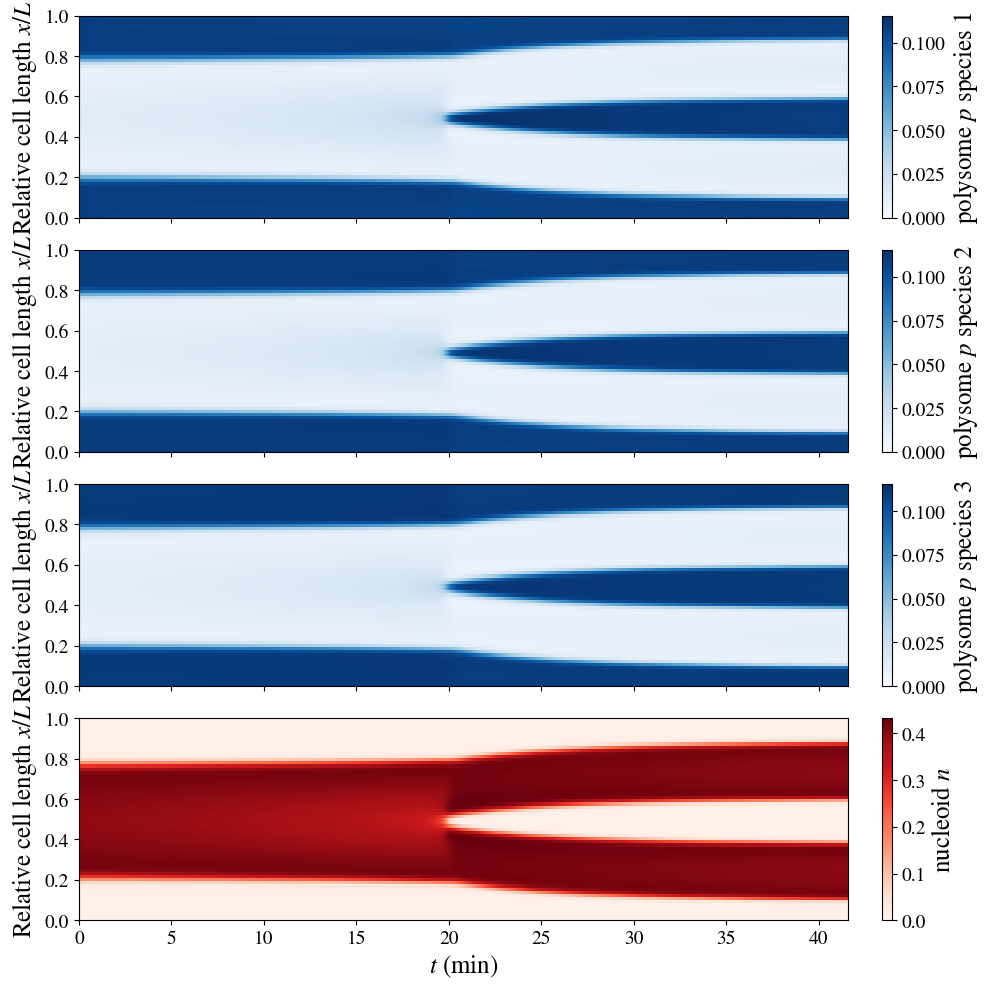

In [20]:
fig, ax = plot_kymograph(t_trace[::steps_skip], phi_trace[::steps_skip])
fig.savefig(f"{ouptput_section}/kymograph_segregation.png", dpi=300)